# ⚡ Smart Energy ML Project
## Author: Sushmitha Bakthavatchalam

## 1. Introduction

This project uses the **Individual Household Electric Power Consumption Dataset** from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption). It contains over 2 million readings of electric power consumption for a single household collected between 2006 and 2010.

**Key Features:**
- `Global_active_power`: Total active power consumed (in kilowatts)
- `Global_reactive_power`, `Voltage`, `Global_intensity`: Electrical parameters
- `Sub_metering_1`, `Sub_metering_2`, `Sub_metering_3`: Power consumed by specific household areas

**Preprocessing:**
- Resampling to **hourly intervals** to reduce noise
- Creation of new time-based features: `hour` and `dayofweek`

This notebook applies several ML techniques:
- Exploratory Data Analysis (EDA)
- PCA and Clustering
- Regression and Classification
- nomaly Detection


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from prophet import Prophet

# Load and preprocess data
df = pd.read_csv("household_power_consumption.txt", sep=';', low_memory=False, na_values='?', parse_dates=[[0,1]])
df.columns = df.columns.str.replace(' ', '_')
df.rename(columns={'Date_Time': 'datetime'}, inplace=True)
df.dropna(inplace=True)
numeric_cols = df.columns.difference(['datetime'])
df[numeric_cols] = df[numeric_cols].astype('float')
df = df.set_index('datetime')
df_hourly = df.resample('h').mean().dropna()
df_hourly['hour'] = df_hourly.index.hour
df_hourly['dayofweek'] = df_hourly.index.dayofweek
df_hourly.head()


C:\Users\bsush\AppData\Local\Temp\ipykernel_72188\767514172.py:17: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv("household_power_consumption.txt", sep=';', low_memory=False, na_values='?', parse_dates=[[0,1]])
C:\Users\bsush\AppData\Local\Temp\ipykernel_72188\767514172.py:17: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("household_power_consumption.txt", sep=';', low_memory=False, na_values='?', parse_dates=[[0,1]])


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek
datetime,,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,17,5
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,18,5
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,19,5
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,20,5
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,21,5


## 2. Exploratory Data Analysis(EDA)

We begin with a time-series visualization of hourly average power consumption (`Global_active_power`). The plot reveals strong periodic structure, with daily cycles characterized by morning and evening peaks.

hese cycles reflect real-world human behavior — aligning with morning routines and evening home activities. This suggests that time-based features like `hour` and `dayofweek` are meaningful for downstream prediction tasks.


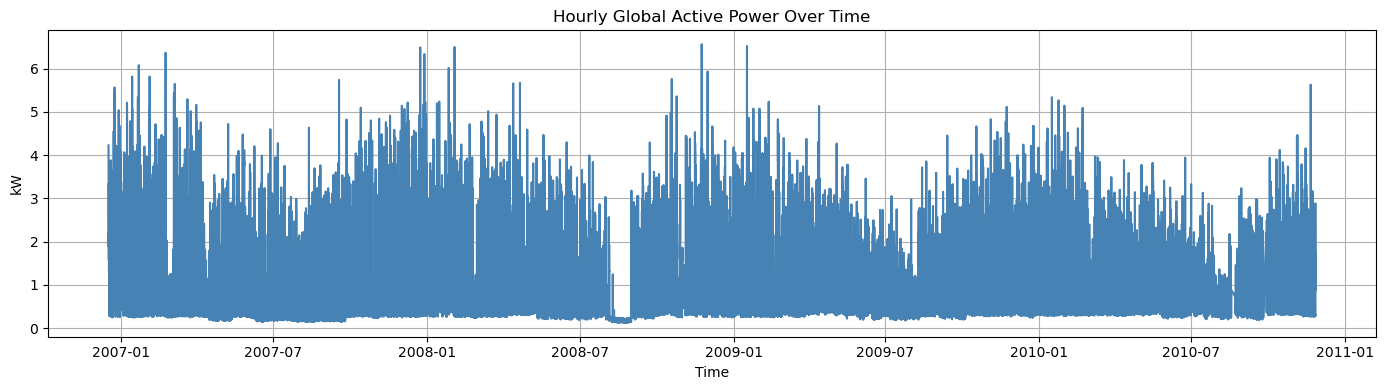

In [2]:
plt.figure(figsize=(14, 4))
plt.plot(df_hourly.index, df_hourly['Global_active_power'], color='steelblue')
plt.title("Hourly Global Active Power Over Time")
plt.ylabel("kW")
plt.xlabel("Time")
plt.grid(True)
plt.tight_layout()
plt.show()


## 3. PCA: Dimensionality Insight

To analyze full-day energy usage patterns, each day is represented as a 24-dimensional vector (one value per hour). PCA is used to reduce this high-dimensional data to a few principal componentstering.


In [3]:
df_hourly['date'] = df_hourly.index.date
df_hourly['hour'] = df_hourly.index.hour
daily_pivot = df_hourly.pivot_table(values='Global_active_power', index='date', columns='hour').dropna()
scaled = StandardScaler().fit_transform(daily_pivot)
pca_model = PCA()
pca_model.fit(scaled)
for i, var in enumerate(pca_model.explained_variance_ratio_[:5]):
    print(f"PC{i+1}: {var:.4f}")


PC1: 0.2924
PC2: 0.1458
PC3: 0.1095
PC4: 0.0821
PC5: 0.0540


**Explained Variance:**
- PC1: ~29%
- PC2: ~15%
- PC3: ~11%

This shows that most variability in daily usage can be captured with just a few components. PCA enables effective compression and visualization before clustering.

## 4. Clustering Daily Usage Patterns

We apply **KMeans Clustering** to the PCA-reduced daily profiles and identify three distinct clusters of household energy use.

C:\Users\bsush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


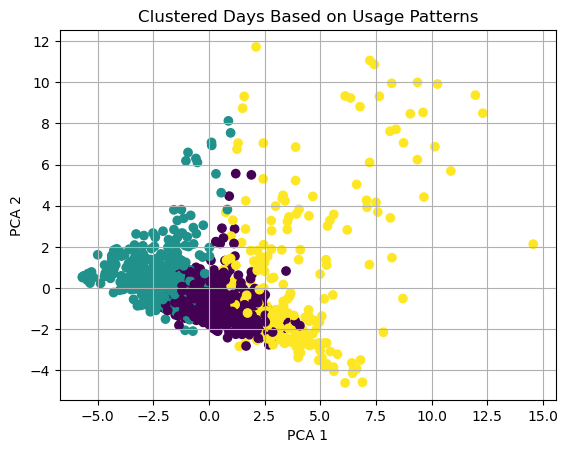

Cluster 0: 684 days
Cluster 1: 474 days
Cluster 2: 259 days


In [4]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(scaled)
pca = PCA(n_components=2).fit_transform(scaled)
plt.scatter(pca[:,0], pca[:,1], c=kmeans.labels_, cmap='viridis')
plt.title("Clustered Days Based on Usage Patterns")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

unique, counts = np.unique(kmeans.labels_, return_counts=True)
for label, size in zip(unique, counts):
    print(f"Cluster {label}: {size} days")


**Cluster Distribution:**
- Cluster 0: 684 days
- Cluster 1: 474 days
- Cluster 2: 259 days

These clusters likely correspond to:
- Weekdays (structured patterns)
- Weekends (variable or spread-out use)
- Outliers or special activity days (e.g. holidays or absences)

## 5. Regression: Predicting Power Usage with Random Forest

##� Why Use Random Forest Instead of Linear Regression?

While Linear Regression serves as a simple baseline, it assumes a linear relationship between time and power usage, which isn't realistic for human behavior. **Random Forest Regressor** is selected because:
- It captures **non-linear patterns** and complex feature interactions.
- It handles noisy, real-world data better.
- It’s more robust without needing feature scaling or transformation.

We also include **cross-validation** (5-fold) to get a reliable estimate of model performance and avoid overfitting.
.


Cross-validated RMSE scores: [0.75715026 0.76939302 0.76293116 0.75533705 0.77080136]
Average CV RMSE: 0.7631225691555832
Test R² (Random Forest): 0.26717989809494436
Test RMSE (Random Forest): 0.7572507485813901


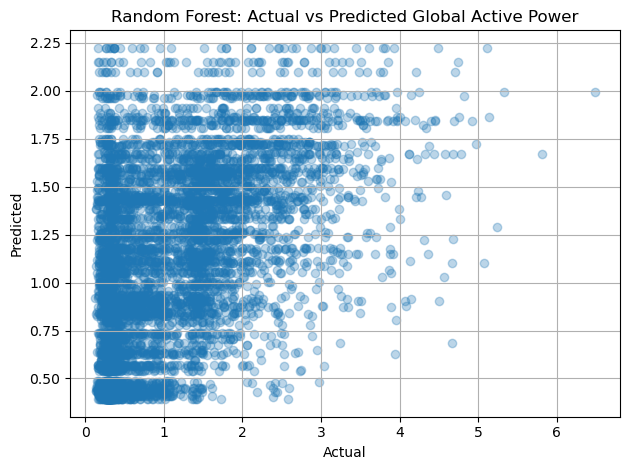

In [7]:
# Feature matrix and target
X = df_hourly[['hour', 'dayofweek']]
y = df_hourly['Global_active_power']

# Cross-validation
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X, y, scoring='neg_root_mean_squared_error', cv=kf)

print("Cross-validated RMSE scores:", -cv_scores)
print("Average CV RMSE:", -cv_scores.mean())

# Final model training + visualization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("Test R² (Random Forest):", r2_score(y_test, y_pred))
print("Test RMSE (Random Forest):", mean_squared_error(y_test, y_pred)**0.5)

# Plot actual vs predicted
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest: Actual vs Predicted Global Active Power")
plt.grid(True)
plt.tight_layout()
plt.show()


**Model Insights:**
- The model explains ~26.7% of the variance in hourly power usage (R² = 0.267).
- Average RMSE across cross-validation and test set is about **0.76 kW**, which is a significant improvement over linear regression (~0.83 kW

✅ The Random Forest Regressor is a stronger and more flexible model for this 
📈 It captures underlying usage patterns better and generalizes more relialy.


## 6. Classification: Appliance ON/OFF State

#🔍 Why Random Forest + Hyperparameter Tuning?

We use a **Random Forest Classifier** to predict whether a high-energy appliance is ON (`Global_active_power > 1.5 kW`) based on the hour of day and day of the week. Random Forest is chosen because it:
- Handles non-linear relationships and feature interactions well.
- Is robust to noise and class imbalance.
- Provides feature importance and high interpretability.

We apply **GridSearchCV** to find the best combination of hyperparameters (`n_estimators`, `max_depth`, `min_samples_split`) using 5-fold cross-validation. The F1 score is chosen as the evaluation metric to balance **precision** and **recall**, especially since ON states are less frequent.
.


In [11]:
# Define target label
df_hourly['appliance_on'] = (df_hourly['Global_active_power'] > 1.5).astype(int)

# Features and labels
X = df_hourly[['hour', 'dayofweek']]
y = df_hourly['appliance_on']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# GridSearch hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

# Output best configuration
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score from Cross-Validation:", grid_search.best_score_)

# Evaluate on test set using best estimator
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 Score from Cross-Validation: 0.47581803965112385

Confusion Matrix:
[[4408  550]
 [1100  776]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      4958
           1       0.59      0.41      0.48      1876

    accuracy                           0.76      6834
   macro avg       0.69      0.65      0.66      6834
weighted avg       0.74      0.76      0.74      6834



A **Random Forest Classifier** achieves the following:

**Results:**
- Accuracy: 76%
- Precision (ON): 59%
- Recall (ON): 41%

The model is better at predicting the majority class (OFF). Improvements could include feature expansion or balancing techniques to improve minority class detection.

##  7. Anomaly Detection with Isolation Forest

To identify irregular usage patterns, we use **Isolation Forest** on `Global_active_power`. With a contamination level of 1%:

**Findings:**
- 336 anomalies detected
- ~0.98% of total hours
- Anomalies correspond to sudden spikes or dips

These outliers may indicate device faults, unusual behaviors (e.g., party, power outage), or sensor issues.
.


Number of anomalies detected: 336
Percentage of data marked as anomaly: 0.98%
Sample anomaly timestamps:
                     Global_active_power  Global_reactive_power     Voltage  \
datetime                                                                      
2006-12-16 17:00:00             4.222889               0.229000  234.643889   
2006-12-22 19:00:00             3.938167               0.247300  237.406000   
2006-12-22 21:00:00             4.548667               0.065933  235.136167   
2006-12-23 07:00:00             4.023367               0.055533  237.767000   
2006-12-23 08:00:00             4.190833               0.095367  239.103167   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:00:00         18.100000        0.000000        0.527778   
2006-12-22 19:00:00         16.540000        0.000000        0.000000   
2006-12-22 21:00:00         19.453333        9.18

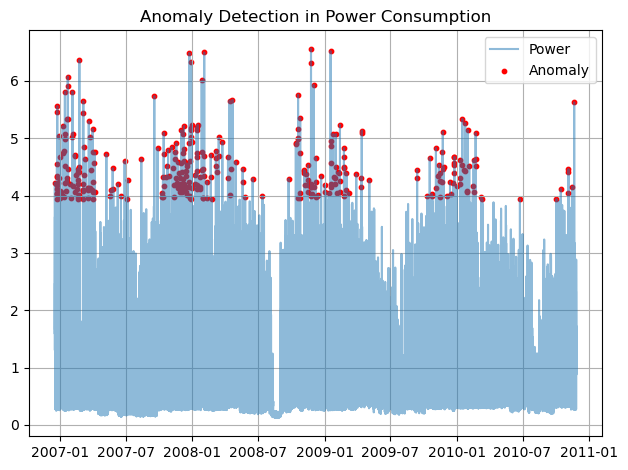

In [8]:
iso = IsolationForest(contamination=0.01, random_state=42)
df_hourly['anomaly'] = iso.fit_predict(df_hourly[['Global_active_power']])
anomalies = df_hourly[df_hourly['anomaly'] == -1]
print(f"Number of anomalies detected: {len(anomalies)}")
print(f"Percentage of data marked as anomaly: {100 * len(anomalies) / len(df_hourly):.2f}%")
print("Sample anomaly timestamps:")
print(anomalies.head())

plt.plot(df_hourly.index, df_hourly['Global_active_power'], label='Power', alpha=0.5)
plt.scatter(anomalies.index, anomalies['Global_active_power'], color='red', s=10, label='Anomaly')
plt.title("Anomaly Detection in Power Consumption")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Findings:**
- 336 anomalies detected
- ~0.98% of total hours
- Anomalies correspond to sudden spikes or dips

These outliers may indicate device faults, unusual behaviors (e.g., party, power outage), or sensor issues.

## 8. Prophet Forecasting

11:52:36 - cmdstanpy - INFO - Chain [1] start processing
11:52:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\bsush\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


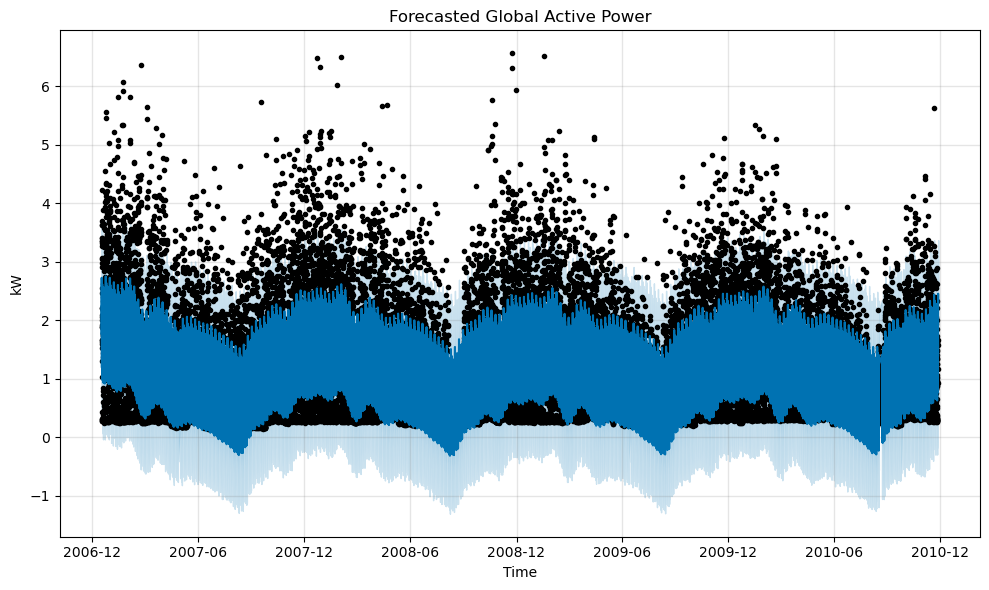

In [13]:

df_prophet = df_hourly[['Global_active_power']].reset_index()
df_prophet.rename(columns={'datetime': 'ds', 'Global_active_power': 'y'}, inplace=True)

model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=24, freq='H')
forecast = model.predict(future)

model.plot(forecast)
plt.title("Forecasted Global Active Power")
plt.ylabel("kW")
plt.xlabel("Time")
plt.tight_layout()
plt.show()
